In [76]:
%pip install -q retina-face deepface scikit-learn pandas matplotlib opencv-python tf-keras tensorrt pillow datasets


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Visão Computacional: Problemas de Detecção e Reconhecimento de Faces

In [78]:
# Definições de constantes

DETECTOR_BACKEND = "retinaface"
EMBEDDING_MODEL = "ArcFace"
MODEL_THRESHOLD = 0.68

GALLERY_PATH = "data/gallery.pkl"

## Utilidades

In [81]:
import random
import math
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from deepface import DeepFace
from sklearn.datasets import fetch_lfw_people


def read_img(image_path: str):
    """
    Lê uma imagem do caminho especificado e converte de BGR para RGB.
    """
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


def show_img(img, title="Image"):
    """
    Exibe uma imagem qualquer.
    """
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()


def show_face_detection(face_path, aligned_face, confidence=None, title=""):
    """
    Exibe a imagem original e a face alinhada lado a lado.
    """
    face = read_img(face_path)
    plt.figure(figsize=(10, 4))

    # Imagem original
    plt.subplot(1, 2, 1)
    plt.imshow(face)
    plt.title(f"{title} - Original")
    plt.axis("off")

    # Face alinhada + confiança
    plt.subplot(1, 2, 2)
    if confidence is not None:
        plt.title(f"{title} - Face Alinhada\nConfiança: {confidence:.4f}")
    else:
        plt.title(f"{title} - Face Alinhada")

    plt.imshow(aligned_face)
    plt.axis("off")

    plt.show()


def db_show_random(db: list[dict], db_images: list[np.ndarray], n=10):
    """
    Exibe n imagens aleatórias da base de dados.
    """
    entries = random.sample(db, n)

    entries = sorted(entries, key=lambda e: (e["name"], e["id"]))

    per_row = 10
    rows = math.ceil(n / per_row)

    plt.figure(figsize=(15, 3 * rows))

    for i, entry in enumerate(entries):
        img = db_images[entry["id"]]
        
        plt.subplot(rows, per_row, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{entry['name']}\nID: {entry['id']}", fontsize=7)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


def db_results(probe_image: np.ndarray, results_df: pd.DataFrame, db_images: list[np.ndarray], top_k=3):
    """
    Exibe a imagem de busca e as top_k imagens mais similares da base de dados.
    """
    top = results_df.head(top_k)
    
    plt.figure(figsize=(12, 6))

    plt.subplot(2, top_k, 1)
    plt.imshow(probe_image, cmap='gray')
    plt.title("Probe", fontsize=10)
    plt.axis("off")

    for j in range(1, top_k):
        plt.subplot(2, top_k, j+1)
        plt.axis("off")

    for i, row in enumerate(top.itertuples(), start=1):
        plt.subplot(2, top_k, top_k + i)
        
        idx = int(row.Index)
        img = db_images[idx]

        plt.imshow(img, cmap='gray')
        plt.title(f"{idx} - {row.name}\nDist={row.distance:.4f}", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

## Detecção de Face

#### Localização da Face

In [ ]:
def retinaface_detect(image: str | np.ndarray) -> dict | None:
    faces = DeepFace.extract_faces(image, detector_backend=DETECTOR_BACKEND)
    
    if len(faces) == 0:
        print("Nenhuma face detectada.")
        return None

    # Retorna a primeira face
    face = faces[0]
    # a Face tem
    # {
    #   "face": <img>,
    #   "facial_area": {x, y, w, h, left_eye, right_eye},
    #   "score": <confidence>,
    #
    
    return {
        "face": face["face"],
        "landmarks": face["facial_area"],
        "confidence": face["confidence"],
    }


In [57]:
face_a_path = "data/dicaprio_a.png"
face_b_path = "data/dicaprio_b.png"

face_a_raw = read_img(face_a_path)
face_b_raw = read_img(face_b_path)

face_a = retinaface_detect(face_a_path)
face_b = retinaface_detect(face_b_path)

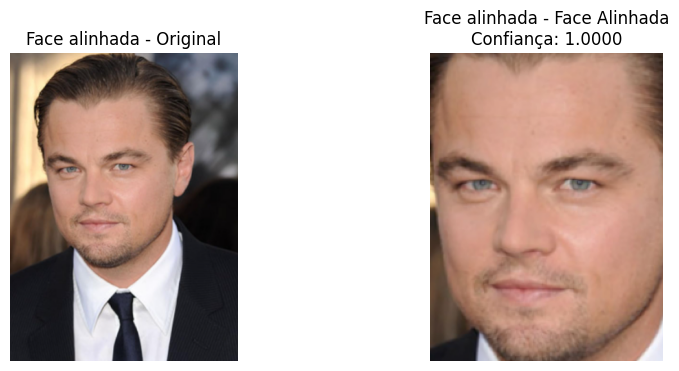

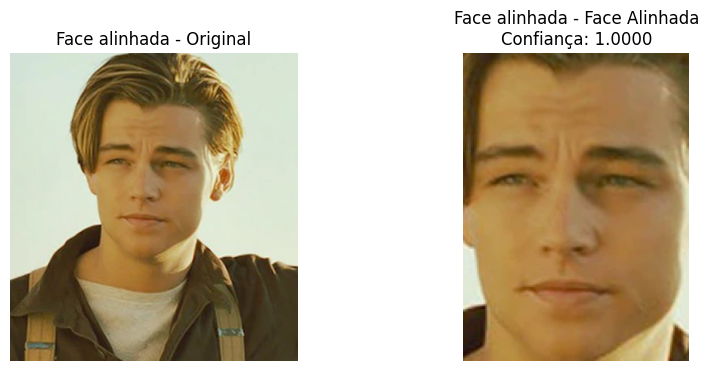

In [62]:
show_face_detection(face_a_path, face_a["face"], face_a["confidence"], title="Face alinhada")
show_face_detection(face_b_path, face_b["face"], face_b["confidence"], title="Face alinhada")

## Reconhecimento

### Representação: Embeddings

In [ ]:
def embed(face, model_name: str = EMBEDDING_MODEL) -> list[float]:
    embedding_objs = DeepFace.represent(img_path=face, model_name=model_name, detector_backend=DETECTOR_BACKEND)
    return embedding_objs[0]["embedding"]


def debug_embedding(embeddings: list[float]) -> None:
    print(f"Modelo: {EMBEDDING_MODEL}")
    print(f"Dimensões: {len(embeddings)}")
    print(f"Primeiros 5 componentes: {embeddings[:5]}")

In [ ]:
face_a_vector = embed(face_a_path)
face_b_vector = embed(face_b_path)

In [69]:
debug_embedding(face_a_vector)
debug_embedding(face_b_vector)

Modelo: ArcFace
Dimensões: 512
Primeiros 5 componentes: [-0.28519943356513977, 0.030191656202077866, -0.13171815872192383, 0.12609495222568512, 0.018713535740971565]
Modelo: ArcFace
Dimensões: 512
Primeiros 5 componentes: [-0.23843708634376526, -0.3730725049972534, 0.09881508350372314, -0.026606649160385132, 0.2364281266927719]


### Verificação 1:1

In [ ]:
def cosine_distance(vec_a: list[float], vec_b: list[float]) -> float:
    source = np.array(vec_a)
    test = np.array(vec_b)
    dot_product = np.dot(source, test)
    source_norm = np.linalg.norm(source)
    test_norm = np.linalg.norm(test)

    return 1 - dot_product / (source_norm * test_norm)


def verify(vec_a: list[float], vec_b: list[float]) -> tuple[bool, float]:
    distance = cosine_distance(vec_a, vec_b)
    verified = distance <= MODEL_THRESHOLD

    return verified, distance

In [67]:
face_c_path = "data/pitt_a.png"
face_c = retinaface_detect(face_c_path)
face_c_vector = embed(face_c_path)

In [68]:
debug_embedding(face_c_vector)

Modelo: ArcFace
Dimensões: 512
Primeiros 5 componentes: [-0.0005617658607661724, 9.98862087726593e-05, 0.08023982495069504, -0.37599000334739685, 0.1665099561214447]


In [70]:
match_ab = verify(face_a_vector, face_b_vector)
match_ac = verify(face_a_vector, face_c_vector)

print("Verificação faces A-B: {}, {} (Cosseno)".format(*match_ab))
print("Verificação faces A-C: {}, {} (Cosseno)".format(*match_ac))

Verificação faces A-B: True, 0.4296575665438428 (Cosseno)
Verificação faces A-C: False, 0.6940850939903676 (Cosseno)


### Verificação 1:N

In [ ]:
# abc

#### Criação de uma Galeria (Banco de Dados vetorial em memória)

As funções abaixo se dedicam à receber o dataset LFW e criar um banco de dados de teste em memória (bem como salvá-lo num arquivo Pickle) com os vetores gerados a partir do modelo ArcFace.

O Banco de Dados vetorial é o nosso banco de identidade que possuí o nome da pessoa e um vetor criado a partir de uma de suas imagens do LFW. Dessa forma, dada uma nova imagem dessa pessoa, podemos gerar o vetor da face dessa nova imagem e consultar no Banco de Dados de pessoas conhecidas para recuperar a identidade a partir da nova imagem.

In [79]:
def embed_array(img_array: np.ndarray, model_name: str = EMBEDDING_MODEL) -> list[float]:
    """
    Gera um vetor de embedding diretamente a partir de um array float64 ou uint8 (formato do LFW).
    """
    # Se vier float [0..1], converte para uint8
    img_uint8 = img_array if img_array.dtype == np.uint8 else (img_array * 255).astype(np.uint8)

    embedding_objs = DeepFace.represent(img_path=img_uint8, model_name=model_name, detector_backend=DETECTOR_BACKEND)
    
    return embedding_objs[0]["embedding"]


def group_by_identity(images, targets, target_names):
    grouped = defaultdict(list)
    for idx, _ in enumerate(images):
        person_name = target_names[targets[idx]]
        grouped[person_name].append(idx)
    return grouped


def split_gallery_probe(grouped):
    gallery_indices = []
    probe_indices = []

    for person, idx_list in grouped.items():
        if len(idx_list) == 1:
            # só 1 foto: fica só na gallery ou skip
            gallery_indices.append(idx_list[0])
        else:
            random.shuffle(idx_list)
            gallery_indices.append(idx_list[0])      # referência
            probe_indices.extend(idx_list[1:])       # probes

    return gallery_indices, probe_indices


def build_gallery_from_indices(images, target_names, targets, gallery_indices, save_path=GALLERY_PATH):
    gallery = []

    for idx in gallery_indices:
        vec = embed_array(images[idx])
        gallery.append({
            "id": idx,
            "name": target_names[targets[idx]],
            "vector": vec
        })

    with open(save_path, "wb") as f:
        pickle.dump(gallery, f)

    print(f"Gallery criada com {len(gallery)} identidades.")
    return gallery


def build_probe_set(images, target_names, targets, probe_indices):
    probes = []

    for idx in probe_indices:
        probes.append({
            "id": idx,
            "name": target_names[targets[idx]],
            "image": images[idx]
        })

    print(f"Probe set criado com {len(probes)} imagens.")
    return probes


#### Busca em uma galeria de imagens

In [84]:
def search_identity(probe_vector, gallery, top_k=1):
    results = []
    for entry in gallery:
        dist = cosine_distance(probe_vector, entry["vector"])
        results.append({
            "name": entry["name"],
            "id": entry["id"],
            "distance": dist
        })
    results = sorted(results, key=lambda x: x["distance"])
    return results[0] if top_k == 1 else results[:top_k]


#### Carregamento do Dataset

In [83]:
# Carregar Dataset LFW
print("Carregando Dataset")
lfw = fetch_lfw_people(min_faces_per_person=2, resize=1.0, color=True)

images = lfw.images
targets = lfw.target
target_names = lfw.target_names

print("Dataset carregado com {} imagens de {} identidades.".format(len(images), len(target_names)))

Carregando Dataset
Dataset carregado com 9164 imagens de 1680 identidades.


In [ ]:
grouped = group_by_identity(images, targets, target_names)
gallery_indices, probe_indices = split_gallery_probe(grouped)

In [ ]:
gallery = build_gallery_from_indices(
    images, target_names, targets,
    gallery_indices,
    save_path="gallery.pkl"
)

In [ ]:
probes = build_probe_set(images, target_names, targets, probe_indices)

##### Demonstração

In [ ]:
def a():
    ...

### Validação

In [ ]:
THRESHOLD = 0.68

total = len(probes)
correct_top1 = 0
true_accept = 0
false_reject = 0
false_accept = 0

# Listas para histograma
genuine_distances = []   # mesma pessoa
impostor_distances = []  # pessoa diferente

print("Rodando avaliação...")

for probe in probes:
    probe_vec = embed_array(probe["image"])
    result = search_identity(probe_vec, gallery)

    same_person = (result["name"] == probe["name"])
    dist = result["distance"]

    # Armazenar para histogramas
    if same_person:
        genuine_distances.append(dist)
    else:
        impostor_distances.append(dist)

    # Rank-1 accuracy
    if same_person:
        correct_top1 += 1

    # Open-set evaluation
    if dist < THRESHOLD:
        if same_person:
            true_accept += 1
        else:
            false_accept += 1
    else:
        if same_person:
            false_reject += 1

#### Resultados

In [ ]:
rank1 = correct_top1 / total
FAR = false_accept / total
FRR = false_reject / total
TAR = true_accept / total

print("\n===== RESULTADOS =====")
print(f"Total de probes: {total}")
print(f"Rank-1 Accuracy: {rank1:.4f}")
print(f"True Accept Rate (TAR): {TAR:.4f}")
print(f"False Accept Rate (FAR): {FAR:.4f}")
print(f"False Reject Rate (FRR): {FRR:.4f}")
print("======================")

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(genuine_distances, bins=30, alpha=0.6, label="Genuínas")
plt.hist(impostor_distances, bins=30, alpha=0.6, label="Impostoras")
plt.axvline(THRESHOLD, linestyle="--", label=f"Limiar = {THRESHOLD}")
plt.xlabel("Distância (cosine-distance)")
plt.ylabel("Frequência")
plt.title("Distribuição das Distâncias: Genuínas vs Impostoras")
plt.legend()
plt.show()